In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import re
import warnings
warnings.filterwarnings("ignore")

In [3]:
elect = pd.read_excel("hourly_electricity.xlsx")
elect["date"] = pd.to_datetime(elect["date"], format='%d.%m.%Y')
elect["time"] = elect["date"].astype(str) + " " + elect["hour"].astype(str)
elect["time"] = pd.to_datetime(elect["time"])
elect.sort_values(by = "time", inplace = True)
elect.set_index("time", inplace=True)
elect.drop(columns="hour", inplace = True)
elect.drop(columns="date", inplace=True)

In [10]:
elect["hour"] = elect.index.hour
elect["week"] = elect.index.weekday
elect["month"] = elect.index.month

In [12]:
elect.head()

,electricity,hour,week,month
time,,,,
2017-01-01 00:00:00,27223.06,0,6,1
2017-01-01 01:00:00,25825.90,1,6,1
2017-01-01 02:00:00,24252.68,2,6,1
2017-01-01 03:00:00,22915.47,3,6,1
2017-01-01 04:00:00,22356.99,4,6,1


In [13]:
elect = pd.get_dummies(data=elect, columns=["hour", "week", "month"])

In [14]:
elect.head()

,electricity,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,27223.06,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 01:00:00,25825.90,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 02:00:00,24252.68,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 03:00:00,22915.47,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 04:00:00,22356.99,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# anomaly detection: IsolationForest

In [23]:

outliers_fraction = float(.005)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(elect.values)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction, n_estimators = 500)
model.fit(data)

IsolationForest(contamination=0.005, n_estimators=500)

In [24]:
elect['anomaly'] = model.predict(data)

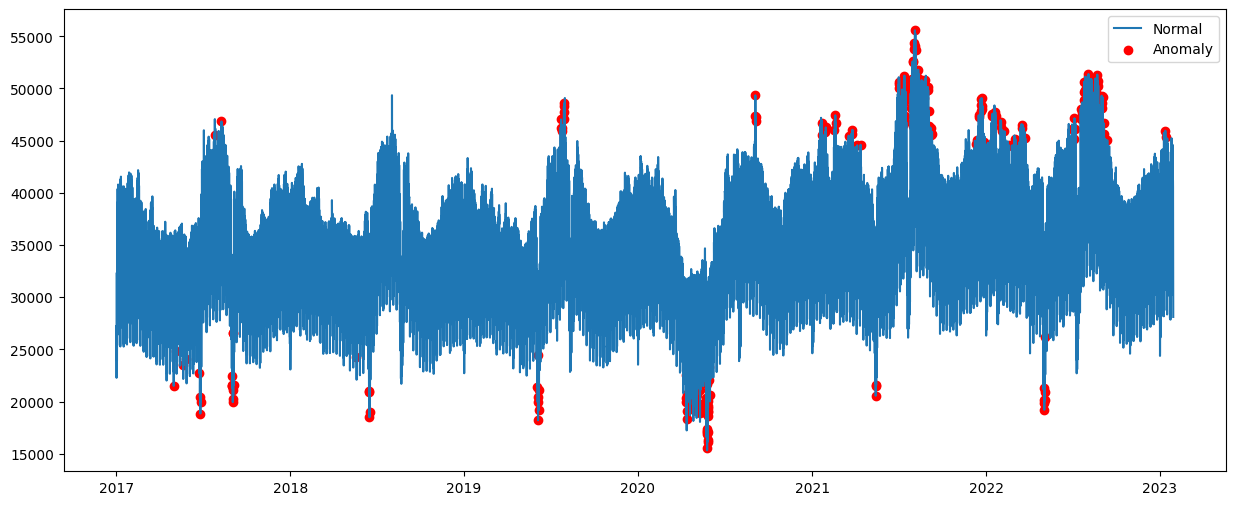

In [25]:
# visualization
fig, ax = plt.subplots(figsize=(15,6))
a = elect.loc[elect['anomaly'] == -1, ['electricity']] #anomaly
ax.plot(elect.index, elect['electricity'], color='C0', label = 'Normal')
ax.scatter(a.index, a['electricity'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [26]:
print("number of outlier days:", len(a))

number of outlier days: 267


# data inputation for anomalies

In [32]:
a_days = a.index # anomaly days

In [34]:
print(a_days)

DatetimeIndex(['2017-05-01 06:00:00', '2017-05-06 06:00:00',
               '2017-05-20 06:00:00', '2017-05-27 06:00:00',
               '2017-06-24 06:00:00', '2017-06-25 06:00:00',
               '2017-06-26 06:00:00', '2017-06-27 06:00:00',
               '2017-07-27 11:00:00', '2017-08-09 14:00:00',
               ...
               '2022-09-01 14:00:00', '2022-09-02 11:00:00',
               '2022-09-02 14:00:00', '2022-09-02 19:00:00',
               '2022-09-05 11:00:00', '2022-09-05 14:00:00',
               '2022-09-09 14:00:00', '2022-09-12 14:00:00',
               '2023-01-12 11:00:00', '2023-01-13 11:00:00'],
              dtype='datetime64[ns]', name='time', length=267, freq=None)


In [ ]:

for i in range(len(a_days)):
    prev_week = a_days[i]+timedelta(-7)
    next_week = a_days[i]+timedelta(7)
    if (prev_week not in a_days) &(next_week not in a_days):
        elect.loc[a_days[i], "electricity"] = (elect.loc[prev_week, "electricity"] + elect.loc[next_week, "electricity"])/2
    elif prev_week in a_days:
        prev_week = prev_week +timedelta(-7)
        elect.loc[a_days[i], "electricity"] = (elect.loc[prev_week, "electricity"] + elect.loc[next_week, "electricity"])/2
    elif next_week in a_days:
        next_week = next_week +timedelta(7)
        elect.loc[a_days[i], "electricity"] = (elect.loc[prev_week, "electricity"] + elect.loc[next_week, "electricity"])/2
    else:
        prev_week = prev_week +timedelta(-7)
        next_week = next_week +timedelta(7)
        elect.loc[a_days[i], "electricity"] = (elect.loc[prev_week, "electricity"] + elect.loc[next_week, "electricity"])/2

# visualization after data iputation

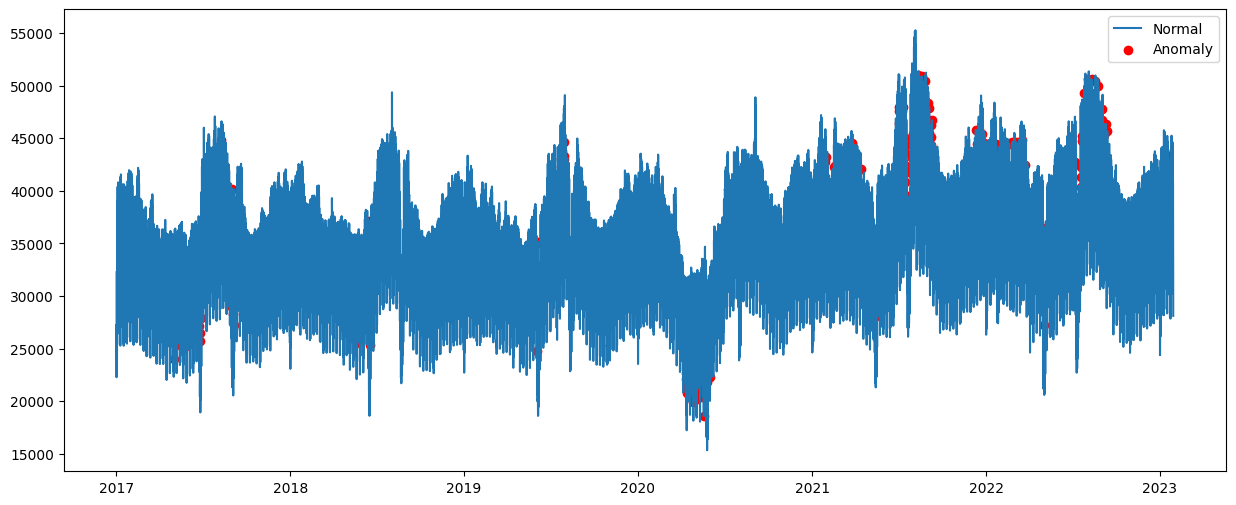

In [31]:
fig, ax = plt.subplots(figsize=(15,6))
a = elect.loc[elect['anomaly'] == -1, ['electricity']] #anomaly
ax.plot(elect.index, elect['electricity'], color='C0', label = 'Normal')
ax.scatter(a.index, a['electricity'], color='red', label = 'Anomaly')
plt.legend()
plt.show()